In this write up I will be developing a Convolutional Neural Network to do image recognition. The hypothetical client has given me a repository of images and they ask if I can build a model that will correctly recognize what's in the images. My assumption here is that this can be predicted, and that there is sufficient data to make this prediction:

_Hypothesis 1:_
 - There is a statistical probability relating the outputs to the inputs (I can beat random).
 
_Hypothesis 2:_
 - There is sufficient data to learn the relationships between the inputs and the outputs.
 
To test this, I will take a quick look at the data, build a base line model, and see if I can apply training tricks, statistical techniques and architectures in the hopes that I will have a powerful prediction engine.

In [1]:
from keras.datasets import cifar10
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

Using TensorFlow backend.


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Load dataset

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### Peek at some samples

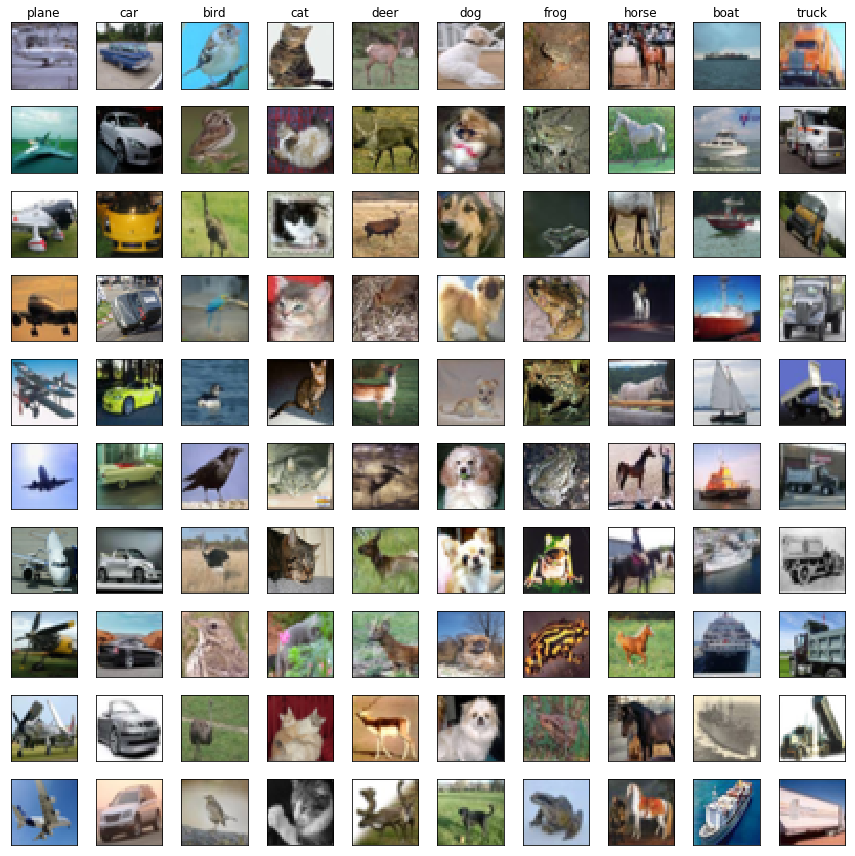

In [73]:
label = {0: 'plane', 1: 'car', 2:'bird', 3:'cat', 4:'deer', 
         5:'dog', 6:'frog', 7:'horse', 8:'boat', 9: 'truck'}

rows, cols = 10, 10
def plot_samples(x_train, y_train, rows, cols):
    
    fig = plt.figure(figsize=(12,12))
    g_s = gridspec.GridSpec(rows, cols)
    # g_s.update(left=0.1,right=0.9,wspace=0.05, top=0.9, bottom=0.1)
    ax = {}
    
    for i in range(cols):
        sample_pics = x_train[(y_train == i).reshape(-1)]
        for j in range(rows):
            num_samples = sample_pics.shape[0]
            random_idx = np.random.choice(num_samples, replace=False) 
            sample_pic = x_train[(y_train == i).reshape(-1)][random_idx]

            ax[(i, j)] = fig.add_subplot(g_s[j, i])
            ax[(i, j)].set_xticks([])
            ax[(i, j)].set_yticks([])
            ax[(i, j)].imshow(sample_pic)
        ax[(i, 0)].set_title(label[i])
    fig.tight_layout()
plot_samples(x_train, y_train, rows, cols);

### Observations
- Some images are not completely centered (padding and sub-sampling might help)
- Background color is diverse within subgroups (model may not train on color scheme of photos?)
- The entire object is contained in each image (easier time for recognition)
- the images are all the same size (no cropping, padding or subsampling necessary)
- there is a perfect distribution of classes (oversampling not necessary)

### Pre-processing data
A good bet is to normalize the data; translate the mean to center about zero and scale the spread to have a standard deviation of 1.

In [5]:
from keras.preprocessing.image import ImageDataGenerator

data = ImageDataGenerator(samplewise_center=True, 
                          samplewise_std_normalization=True,
                          horizontal_flip=True)

data.fit(x_train)

# TODO:
# Add Data Augmentation
# Add padding: Add pixels around image and pick 32x32 spot not centered

### Simple Deep Convolutional Neural Network

In [111]:
from keras.applications.resnet50 import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Dropout
from keras import optimizers
from keras.utils.np_utils import to_categorical

# Data metadata
num_classes = np.max(y_train)
num_train = x_train.shape[0]
in_dim = x_train.shape[1:]

# hyper parameters:
p = 0.25  # Dropout probability 
k = 3     # kernel size for convolution
f1 = 32   # number of filters, convolution 1
f2 = 64   # number of filters, convolution 2

model = Sequential(
        [Conv2D(f1, (k, k), padding='same', name='First-Convolution', input_shape=in_dim),
         Activation('relu', name='First-Relu'),
         Conv2D(f1, (k, k), padding='same', name='Second-Convolution'),
         Activation('relu', name='Second-Relu'),
         MaxPooling2D((2, 2), name='First-Max-Pool'),
         Dropout(p_drop, name='First-Dropout'),
         Conv2D(f2, (k, k), padding='same', name='Third-Convolution'),
         Activation('relu', name='Third-Relu'),
         Conv2D(f2, (k, k), padding='same', name='Fourth-Convolution'),
         Activation('relu', name='Fourth-Relu'),
         MaxPooling2D((2, 2), name='Second-Max-Pool'),
         Dropout(p_drop, name='Second-Dropout'),
         Flatten(name='Flatten'),
         Dense(512, name='First-Affine'),
         Activation('relu', name='Fifth-Relu'),
         Dropout(2*p_drop, name='Third-Dropout'),
         Dense(9, name='Final-Connected-Layer'),
         Activation('softmax', name='Softmax')
        ])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
First-Convolution (Conv2D)   (None, 32, 32, 32)        896       
_________________________________________________________________
First-Relu (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
Second-Convolution (Conv2D)  (None, 32, 32, 32)        9248      
_________________________________________________________________
Second-Relu (Activation)     (None, 32, 32, 32)        0         
_________________________________________________________________
First-Max-Pool (MaxPooling2D (None, 16, 16, 32)        0         
_________________________________________________________________
First-Dropout (Dropout)      (None, 16, 16, 32)        0         
_________________________________________________________________
Third-Convolution (Conv2D)   (None, 16, 16, 64)        18496     
__________

### Things to try:
- leaky relu
- Maxout (Goodfellow et al.)


### Configure Model

In [12]:
SGD = optimizers.SGD(lr=0.001, 
                     decay=.0001, 
                     momentum=0.9, 
                     nesterov=True)

model.compile(loss='categorical_crossentropy', optimizer=SGD, metrics=['categorical_accuracy'])

### Train Model

In [35]:
hist = model.fit_generator(data.flow(x_train,to_categorical(y_train, 10)), epochs=30)

Epoch 1/30
1563/1563 [==============================] - 29s 18ms/step - loss: 1.8457 - categorical_accuracy: 0.3667
Epoch 2/30
1563/1563 [==============================] - ETA: 0s - loss: 1.8094 - categorical_accuracy: 0.37 - 27s 17ms/step - loss: 1.8100 - categorical_accuracy: 0.3786
Epoch 3/30
1563/1563 [==============================] - 28s 18ms/step - loss: 1.7871 - categorical_accuracy: 0.38620s - loss: 1.7868 - catego - ETA: 0s - loss: 1.7872 - categorical_accuracy: 
Epoch 4/30
1563/1563 [==============================] - 28s 18ms/step - loss: 1.7697 - categorical_accuracy: 0.3930
Epoch 5/30
1563/1563 [==============================] - 28s 18ms/step - loss: 1.7586 - categorical_accuracy: 0.3950
Epoch 6/30
1563/1563 [==============================] - 28s 18ms/step - loss: 1.7475 - categorical_accuracy: 0.3992
Epoch 7/30
1563/1563 [==============================] - 29s 19ms/step - loss: 1.7363 - categorical_accuracy: 0.40310s - loss: 1.7
Epoch 8/30
1563/1563 [======================

10000/10000 [==============================] - 1s 108us/step


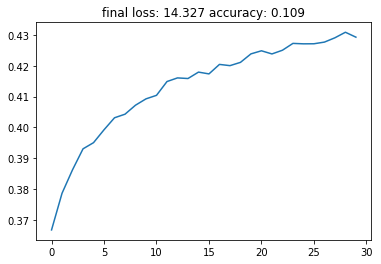

In [36]:
plt.title('final loss: {:1.3f} accuracy: {:1.3f}'.format(*model.evaluate(x_test, to_categorical(y_test, 10))))
plt.plot(hist.history['categorical_accuracyl']);

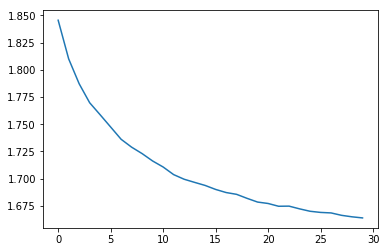

In [38]:
plt.plot(hist.history['loss']);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

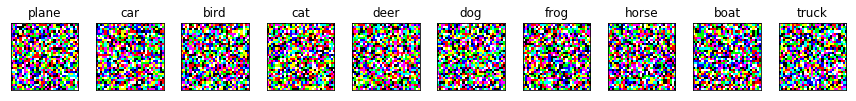

In [74]:
weights = model.get_weights()[0].reshape(-1,32,32,3)
plot_samples(weights * 255, np.arange(10), 1, 10)

9